### Importing Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import pickle

In [35]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from imblearn.metrics import geometric_mean_score
from imblearn.metrics import specificity_score
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import make_scorer
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from pandas.plotting import table
import dataframe_image as dfi

In [3]:
# plt.rc('font', family='serif')
# plt.rc('text', usetex=True)

### Selecting Path

In [4]:
path = r'E:\Eighth Semester\EEE Capstone\8th Semester\Orange'
os.chdir(path)

### Loading Dataset

In [6]:
df_load = pd.read_csv('SyriaTel (Orange 80+20 with mobile no).csv')
df = df_load.drop(columns='phone number').copy()

In [1]:
# Assuming you have a DataFrame called 'df' with a column named 'churn'
churn_counts = df.churn.value_counts().rename({False: 'No', True: 'Yes'}).copy()
total = churn_counts.sum()

# Calculate the ratios
churn_ratios = churn_counts / total

# Create a bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(churn_ratios.index, churn_ratios.values)
plt.xlabel('Churn')
plt.ylabel('Ratio')
plt.title('Churn Distribution')

# Add ratio labels on top of the bars
for bar, ratio in zip(bars, churn_ratios):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{ratio:.2%}', ha='center', va='bottom')

# Save the plot as PNG, PDF, and EPS with dpi 300
plt.savefig('churn_distribution_ratios.png', dpi=300)
plt.savefig('churn_distribution_ratios.pdf', dpi=300)
plt.savefig('churn_distribution_ratios.eps', dpi=300)

# Show the plot
plt.show()


NameError: name 'df' is not defined

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   international plan      3333 non-null   object 
 4   voice mail plan         3333 non-null   object 
 5   number vmail messages   3333 non-null   int64  
 6   total day minutes       3333 non-null   float64
 7   total day calls         3333 non-null   int64  
 8   total day charge        3333 non-null   float64
 9   total eve minutes       3333 non-null   float64
 10  total eve calls         3333 non-null   int64  
 11  total eve charge        3333 non-null   float64
 12  total night minutes     3333 non-null   float64
 13  total night calls       3333 non-null   int64  
 14  total night charge      3333 non-null   

In [10]:
df.nunique()

state                       51
account length             212
area code                    3
international plan           2
voice mail plan              2
number vmail messages       46
total day minutes         1667
total day calls            119
total day charge          1667
total eve minutes         1611
total eve calls            123
total eve charge          1440
total night minutes       1591
total night calls          120
total night charge         933
total intl minutes         162
total intl calls            21
total intl charge          162
customer service calls      10
churn                        2
dtype: int64

### Converting churn column from boolean to integer

In [11]:
df['churn'] = df['churn'].astype(int)

In [12]:
df.churn.value_counts(), df['international plan'].value_counts(), df['voice mail plan'].value_counts()

(churn
 0    2850
 1     483
 Name: count, dtype: int64,
 international plan
 no     3010
 yes     323
 Name: count, dtype: int64,
 voice mail plan
 no     2411
 yes     922
 Name: count, dtype: int64)

###### Encoding

In [13]:
df['international plan'] = df['international plan'].map({'yes':1, 'no':0})
df['voice mail plan'] = df['voice mail plan'].map({'yes':1, 'no':0})

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   international plan      3333 non-null   int64  
 4   voice mail plan         3333 non-null   int64  
 5   number vmail messages   3333 non-null   int64  
 6   total day minutes       3333 non-null   float64
 7   total day calls         3333 non-null   int64  
 8   total day charge        3333 non-null   float64
 9   total eve minutes       3333 non-null   float64
 10  total eve calls         3333 non-null   int64  
 11  total eve charge        3333 non-null   float64
 12  total night minutes     3333 non-null   float64
 13  total night calls       3333 non-null   int64  
 14  total night charge      3333 non-null   

In [ ]:
#df.info()
#df.nunique(), df.columns

### Plotting relations of some features with churn

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


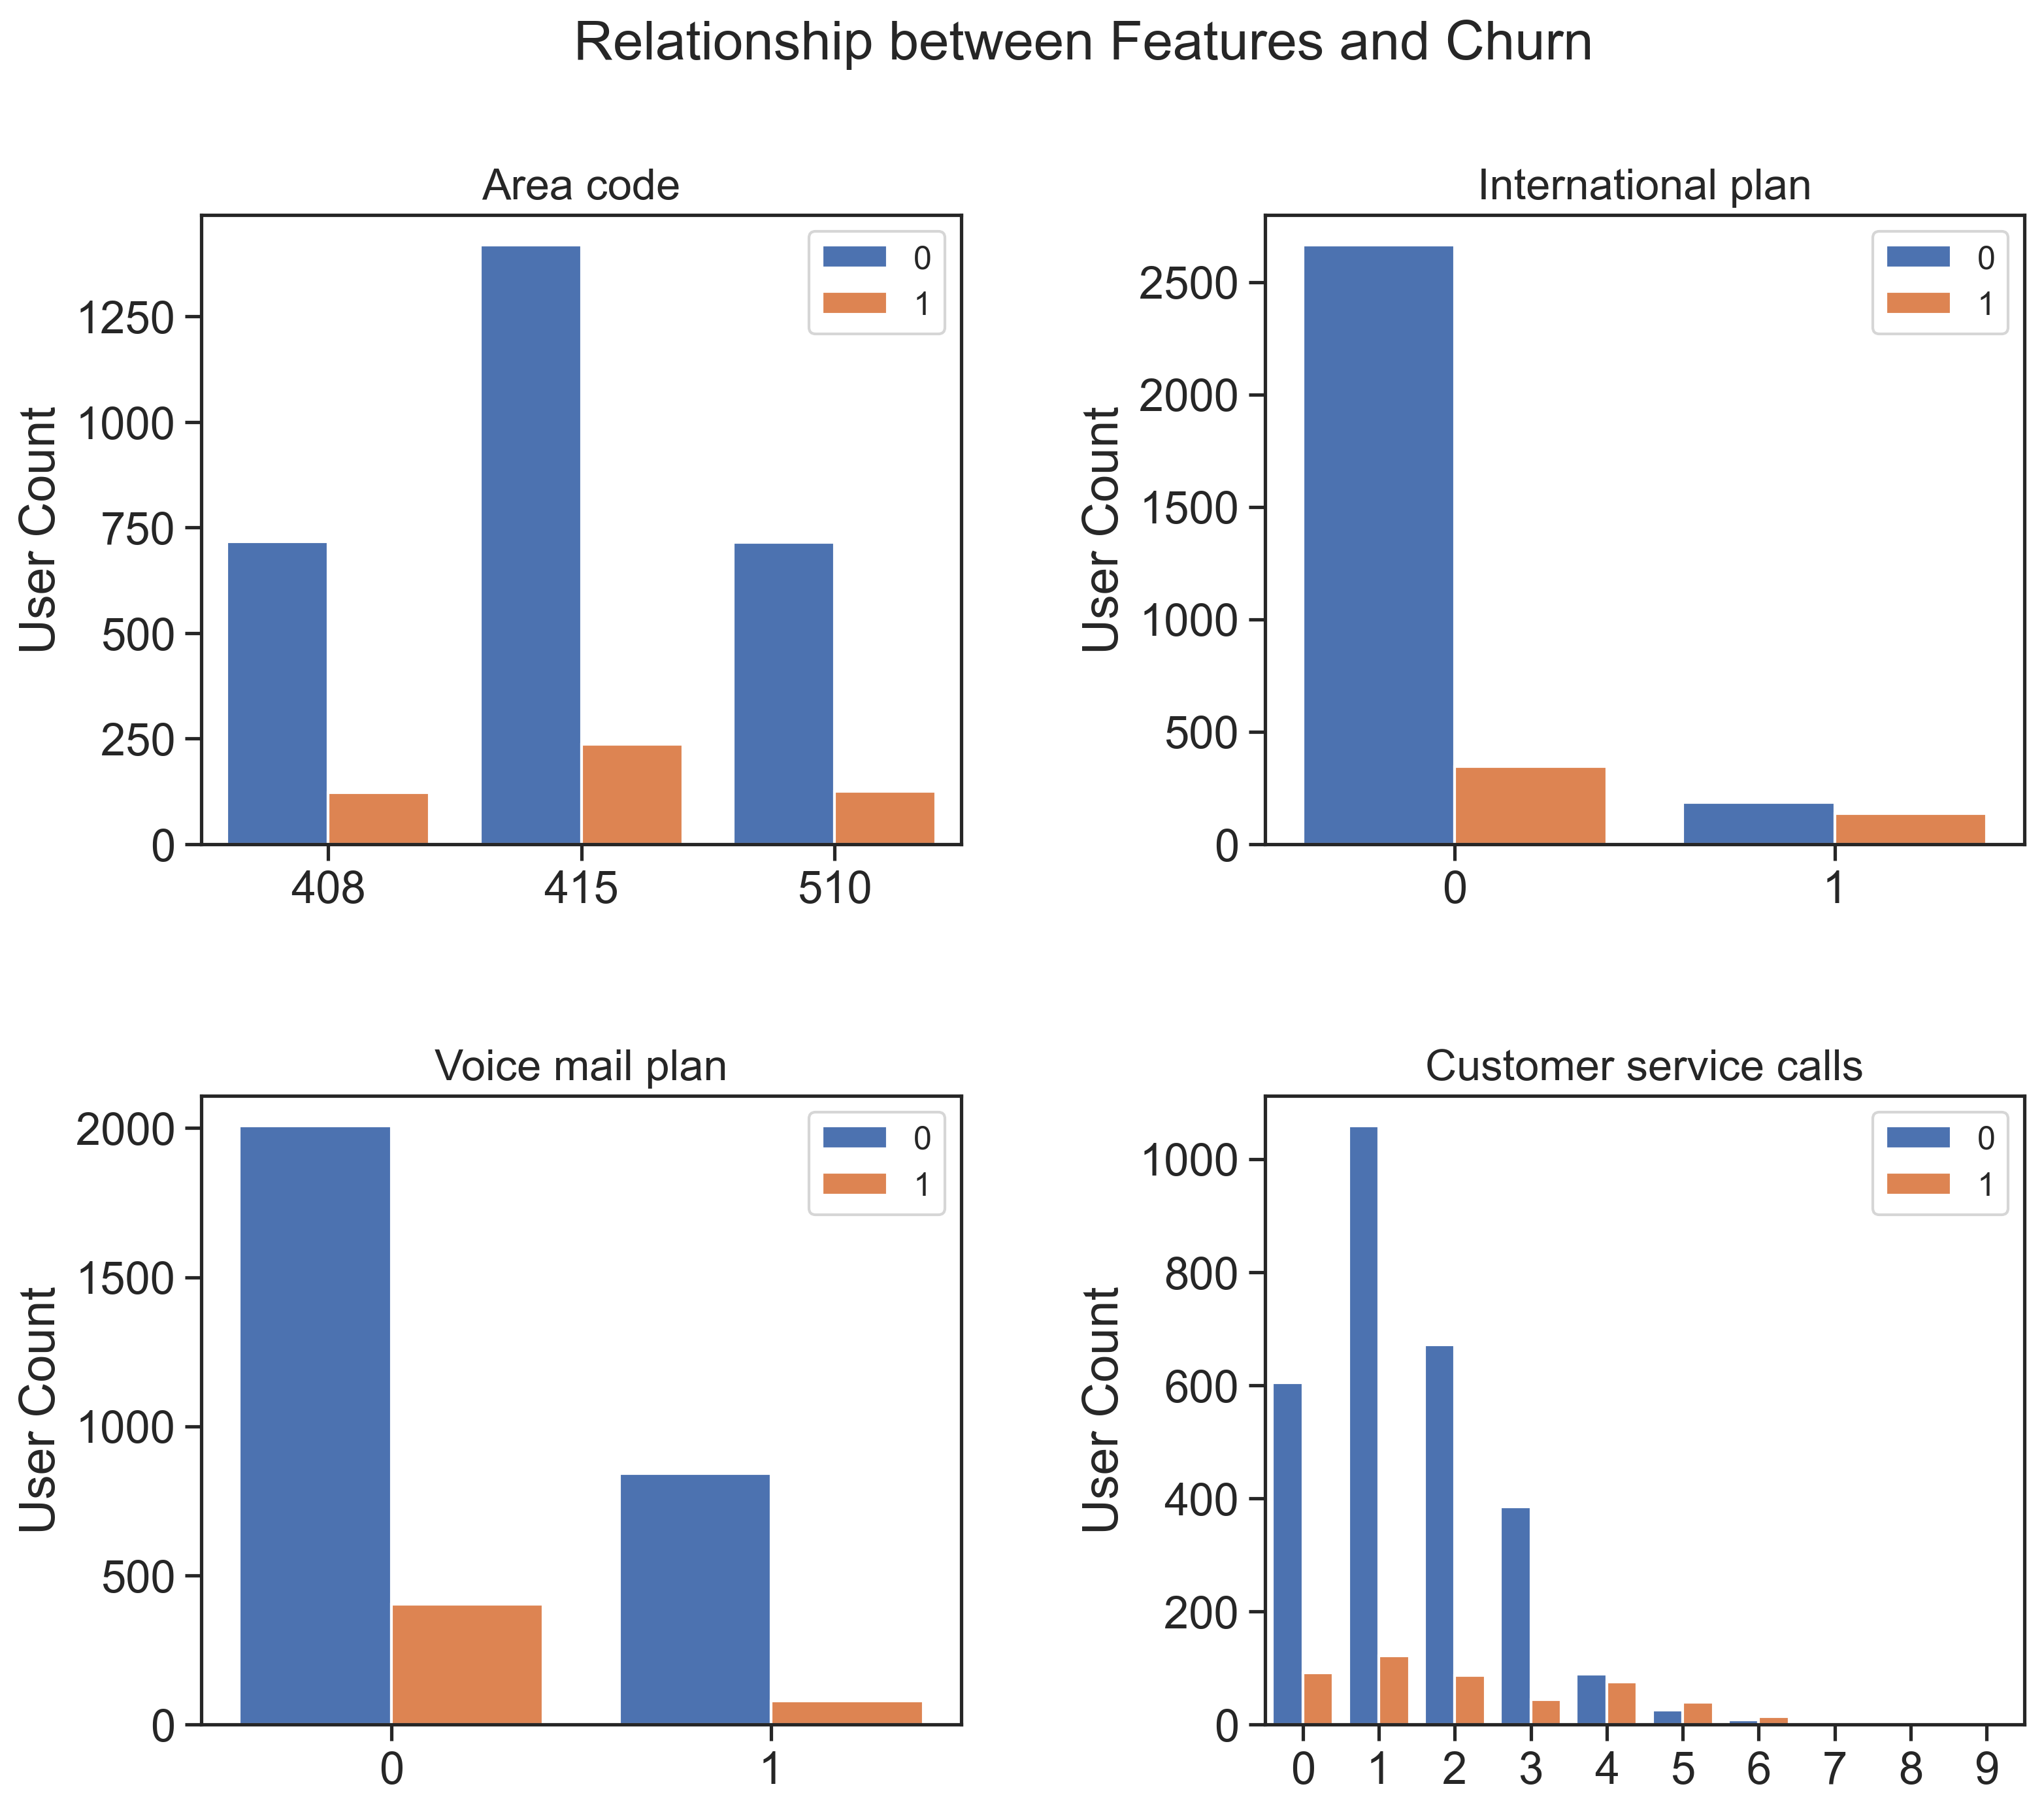

In [14]:
# Select the features to plot
features = ['area code', 'international plan', 'voice mail plan', 'customer service calls']

# Calculate number of rows and columns required for the subplots
n_rows = int(np.ceil(len(features)/2))
n_cols = 2

# Set the plot style to a style suitable for scientific journals
sns.set(style="ticks", font_scale=1.5)

# Define the color palette
#colors = {0: '#3366cc', 1: '#cc3300'}

# Create the figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12,5*n_rows), dpi=300)

# Flatten the axes
axes = axes.flatten()

# Loop through each feature and create the countplot
for i, feature in enumerate(features):
    ax = sns.countplot(x=feature, hue='churn', #palette='Set1', 
                       saturation=1, data=df, ax=axes[i])
    ax.set_xlabel(None)
    ax.set_ylabel('User Count')
    ax.set_title(f'{feature.capitalize()}', fontsize=16)
    ax.legend(loc='upper right', fontsize=12)
    
# Add a title to the figure
fig.suptitle('Relationship between Features and Churn', fontsize=20)

# Remove extra whitespace between subplots
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Save the figure in different formats suitable for submission
plt.savefig('feature_relation.png', bbox_inches='tight')
plt.savefig('feature_relation.pdf', bbox_inches='tight')
plt.savefig('feature_relation.eps', bbox_inches='tight')

### Label Encoding 'State' Column

In [21]:
# create label encoder
le = LabelEncoder()
# select column to be encoded
col_to_encode = 'state'
# create a copy of the dataframe
df_encoded = df.copy()
# fit and transform the column
df_encoded[col_to_encode] = le.fit_transform(df[col_to_encode])

In [23]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   int32  
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   international plan      3333 non-null   int64  
 4   voice mail plan         3333 non-null   int64  
 5   number vmail messages   3333 non-null   int64  
 6   total day minutes       3333 non-null   float64
 7   total day calls         3333 non-null   int64  
 8   total day charge        3333 non-null   float64
 9   total eve minutes       3333 non-null   float64
 10  total eve calls         3333 non-null   int64  
 11  total eve charge        3333 non-null   float64
 12  total night minutes     3333 non-null   float64
 13  total night calls       3333 non-null   int64  
 14  total night charge      3333 non-null   

In [ ]:
#from sklearn.preprocessing import OneHotEncoder

# Select the columns to one-hot encode
#cols_to_encode = ['State']
#cols_to_keep = list(set(df.columns) - set(cols_to_encode))

#get the columns to be encoded as 2D array
#data_to_encode = df[cols_to_encode].values

# One-hot encode the selected columns
#ohe = OneHotEncoder()
#encoded_data = ohe.fit_transform(data_to_encode)

# Get the column names for the encoded DataFrame
#encoded_cols = ohe.get_feature_names_out(cols_to_encode)

# Create the encoded DataFrame
#df_encoded = pd.DataFrame(encoded_data.toarray(), columns=encoded_cols)

# Append the other columns
#df_encoded = pd.concat([df_encoded, df[cols_to_keep].reset_index(drop=True)], axis=1)

In [ ]:
df_encoded

In [25]:
df_encoded.to_csv('df_encoded.csv', index=False)

### Normalization

In [26]:
# Create an instance of MixMaxScaler
#scaler = StandardScaler()

scaler = MinMaxScaler().set_output(transform="pandas") 

# Fit the scaler to the DataFrame
scaler.fit(df_encoded)

# Transform the DataFrame
df_normalized = scaler.transform(df_encoded)

# Feature Selection

### Correlation

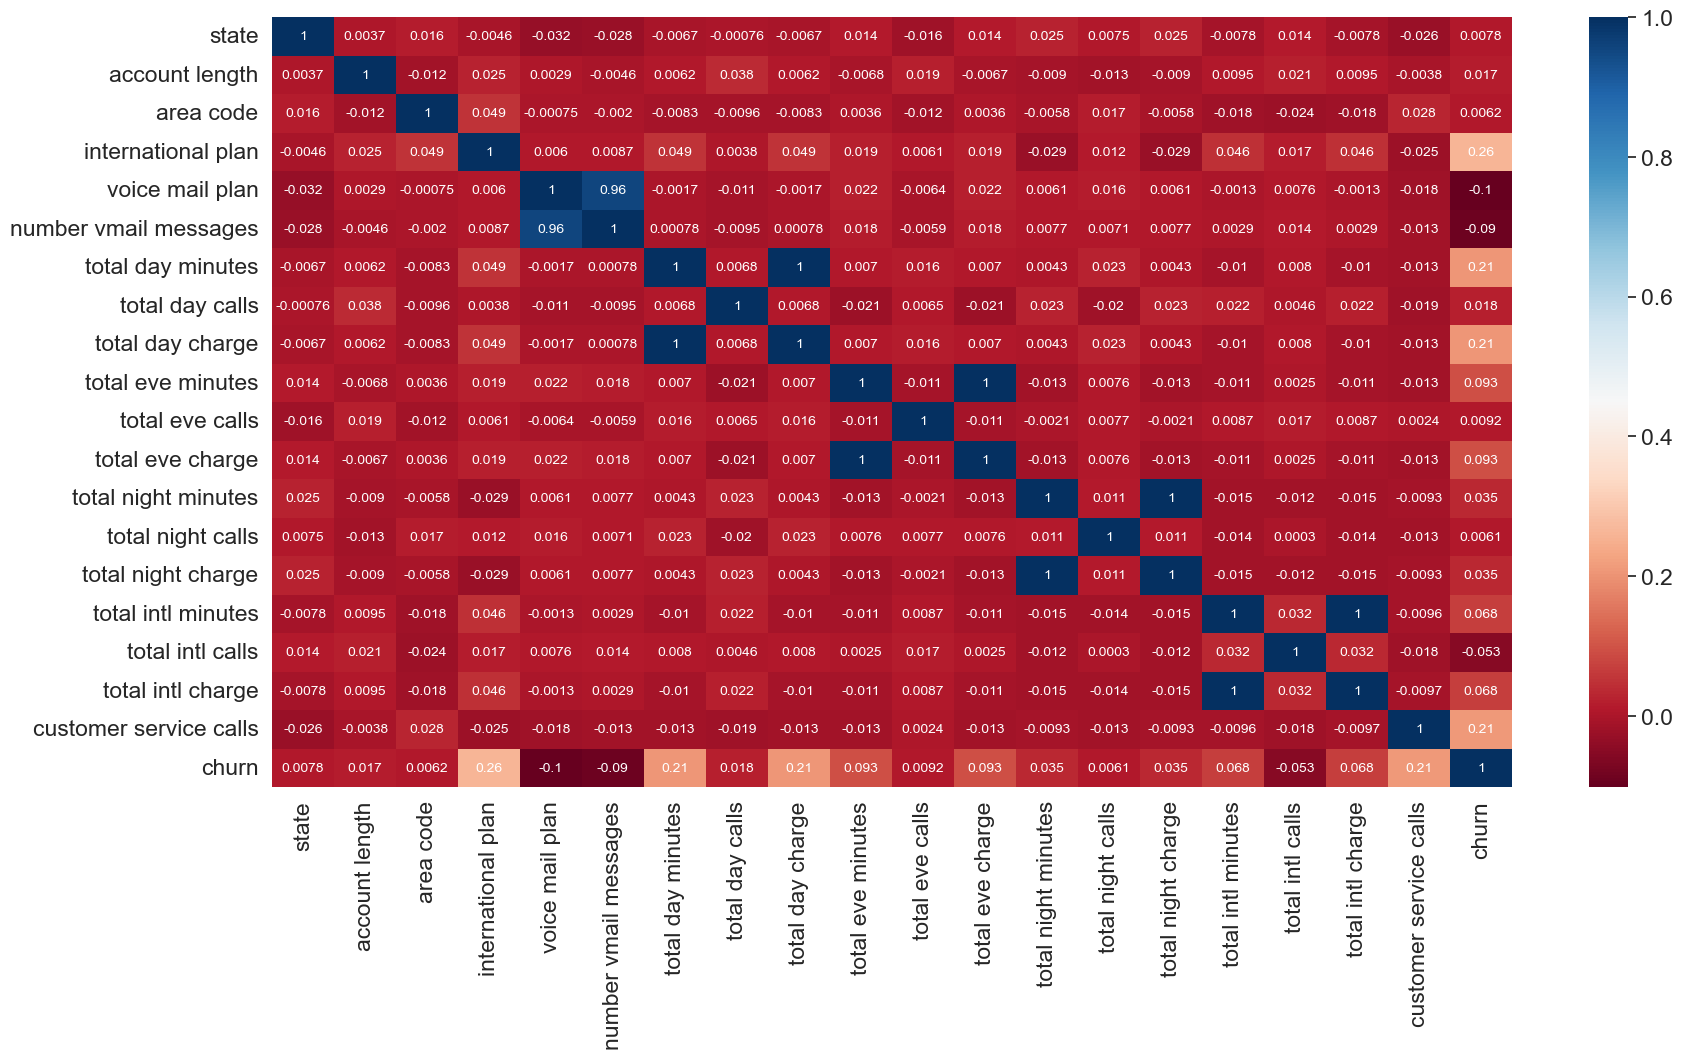

In [30]:
corr = df_normalized.corr()

plt.figure(figsize=(20,10)) # this sets the size of the figure to width=10 inches, height=8 inches
sns.heatmap(corr, annot=True, cmap='RdBu', annot_kws={"size": 10, "color": "white"})
plt.show()

In [31]:
#separate the target variable
y = df_normalized['churn']
X = df_normalized.drop(columns=['churn'])

#calculate correlation
corr = abs(X.corrwith(y))

# sort correlation values in descending order
corr = corr.sort_values(ascending=False)

# number of top k correlation features
k = 10

# get the top k correlation features
top_k_features = corr.index[:k]
corr_features = top_k_features

# plt.figure(figsize=(15,8))
# # plot the correlation values in a bar plot
# sns.barplot(x=corr.values, y=corr.index)
# plt.xlabel('Correlation with target variable')
# plt.ylabel('Features')
# plt.show()

print("Column names of the {} best features:".format(k))
#print the column names of top k correlation features
print(top_k_features)

Column names of the 10 best features:
Index(['international plan', 'customer service calls', 'total day minutes',
       'total day charge', 'voice mail plan', 'total eve minutes',
       'total eve charge', 'number vmail messages', 'total intl charge',
       'total intl minutes'],
      dtype='object')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


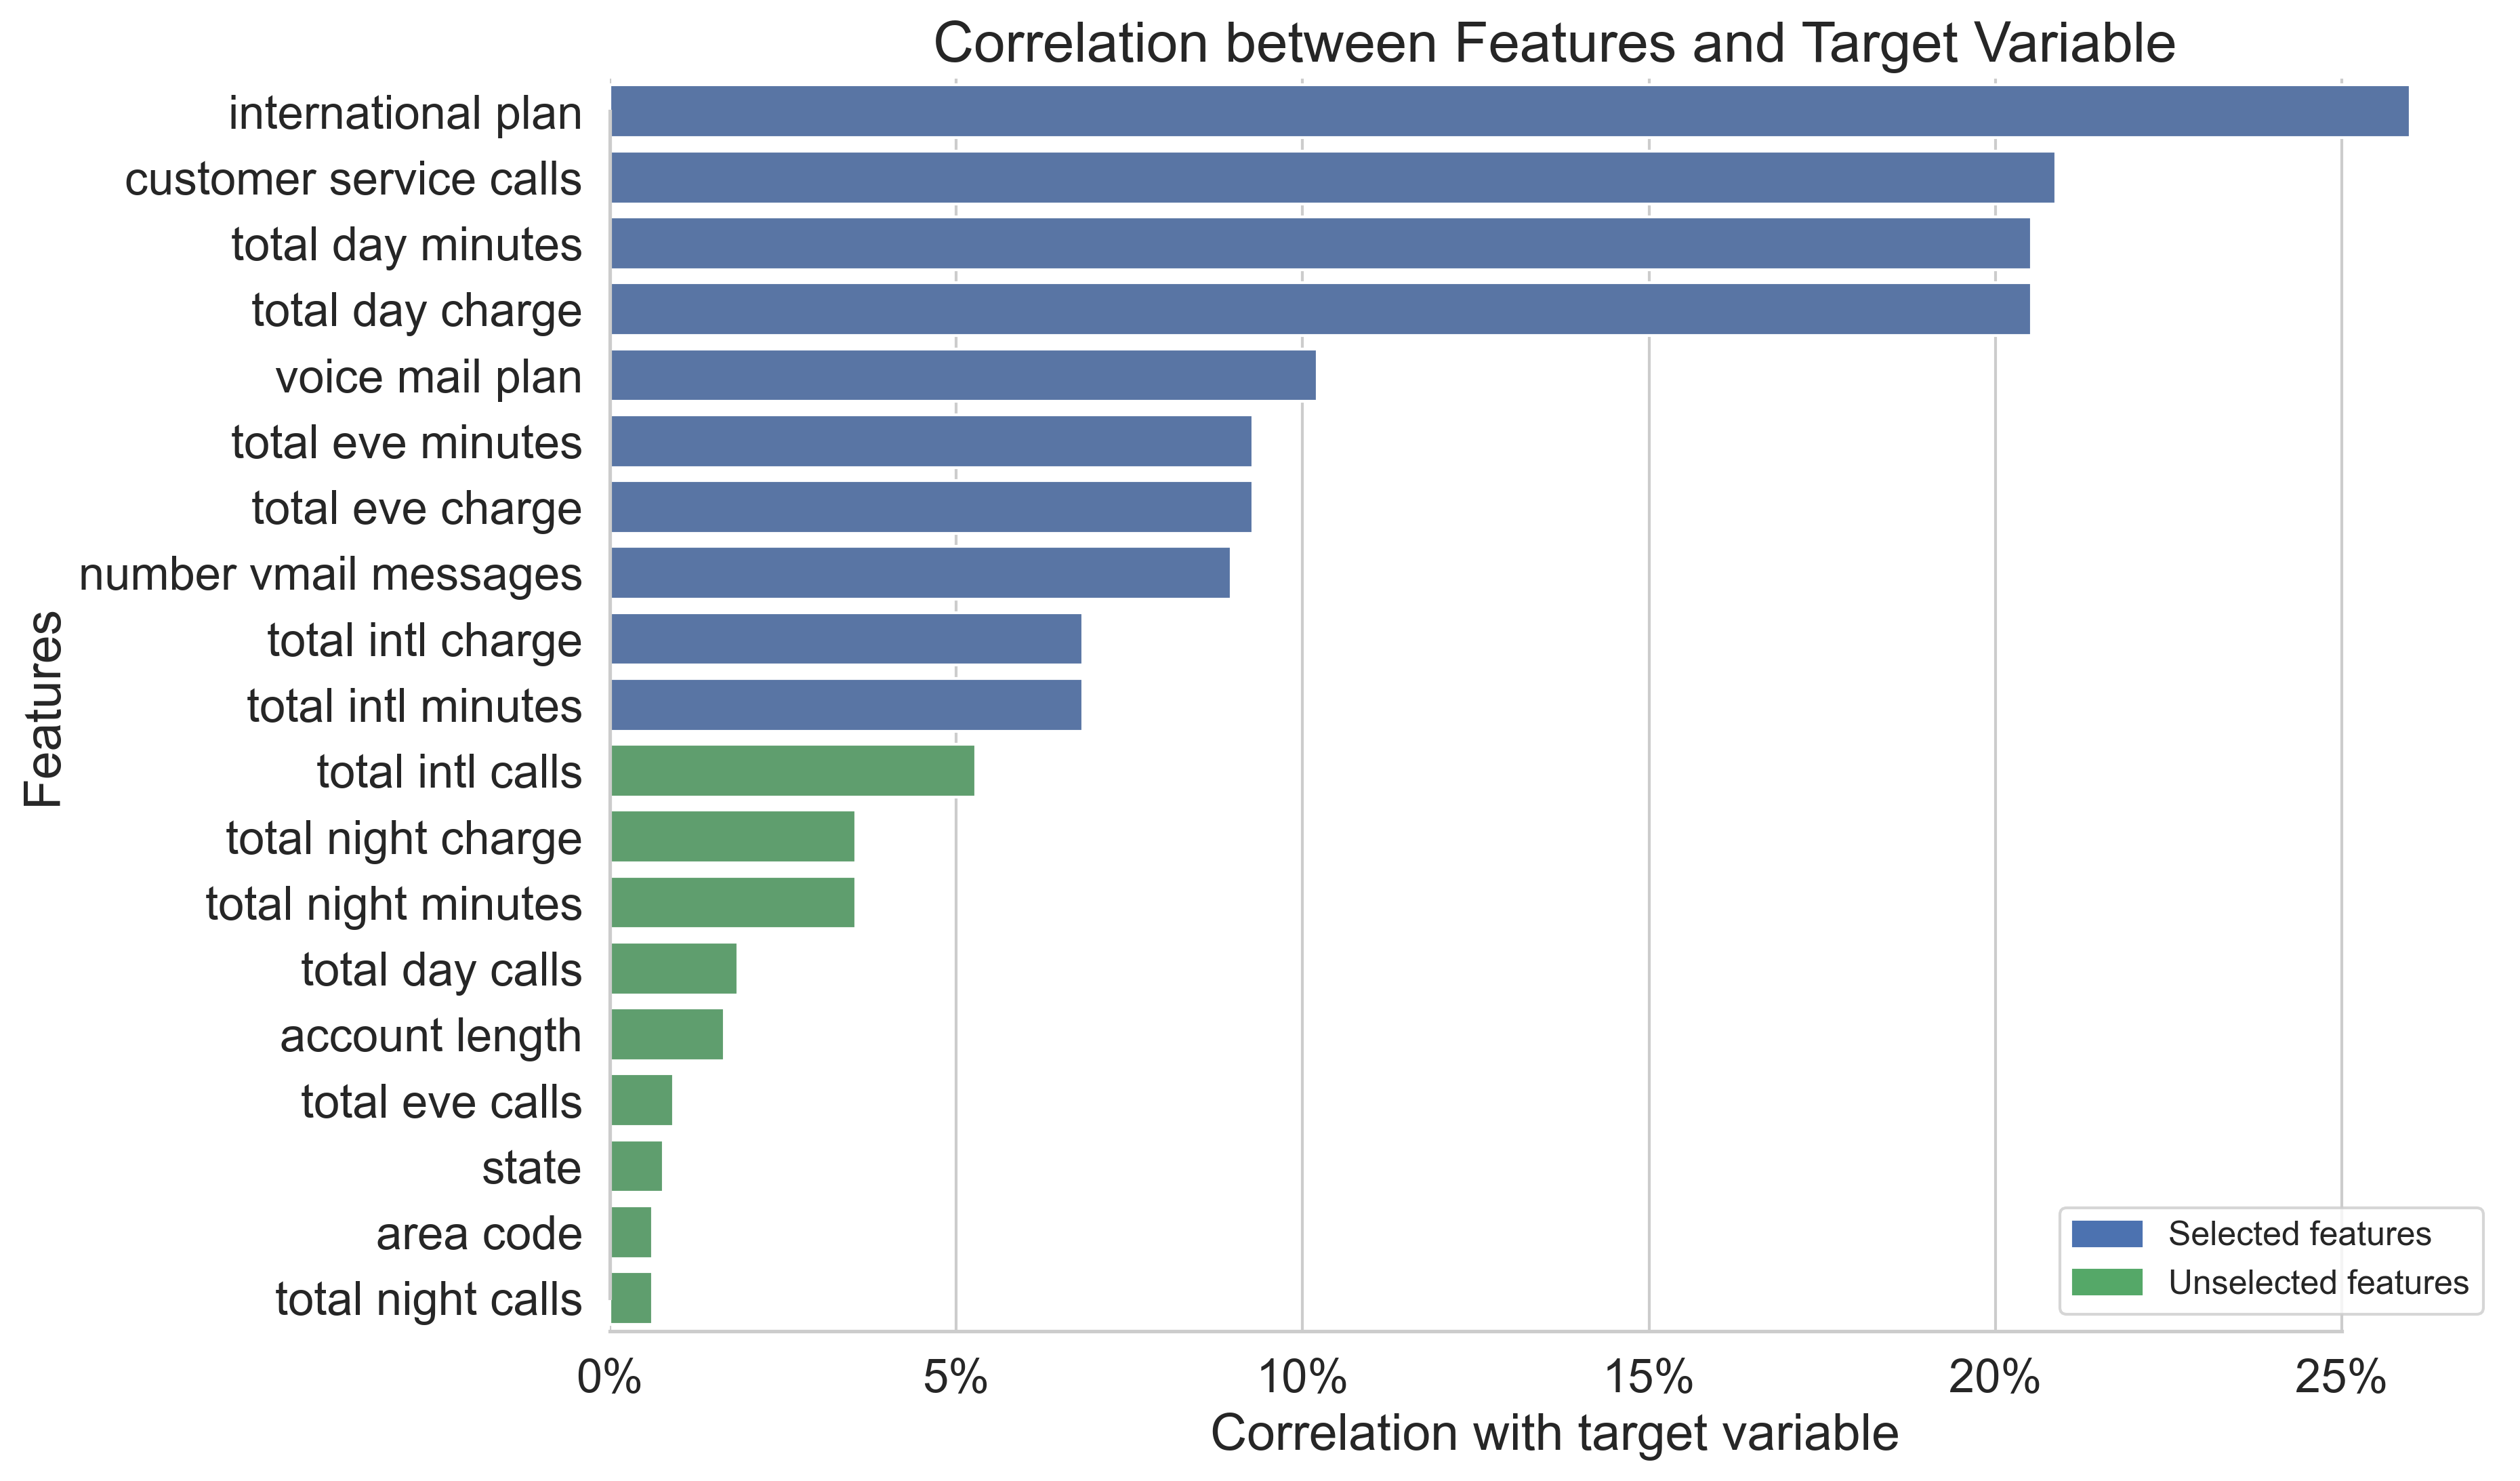

In [32]:
# Set the plot style to a style suitable for scientific journals
sns.set(style="whitegrid", font_scale=1.5)

# Define the figure size and create the figure object
fig, ax = plt.subplots(figsize=(12, 8), dpi=300)

# Sort the correlation values in descending order
corr_sorted = corr.sort_values(ascending=False)

# Define a dictionary to map each feature to a color
colors = {feat: '#4C72B0' if feat in top_k_features else '#55A868' for feat in corr_sorted.index}

# Create the bar plot with custom color
sns.barplot(x=corr_sorted.values, y=corr_sorted.index, palette=colors, ax=ax)

# Set the x and y labels
ax.set_xlabel('Correlation with target variable')
ax.set_ylabel('Features')

# Add a title to the figure
ax.set_title('Correlation between Features and Target Variable', fontsize=20)

# Set the x axis tick labels to display as percentage
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

# Add a legend to indicate selected and unselected features
selected_patch = mpatches.Patch(color='#4C72B0', label='Selected features')
unselected_patch = mpatches.Patch(color='#55A868', label='Unselected features')
ax.legend(handles=[selected_patch, unselected_patch], fontsize=12)

# Adjust the spacing between the bars and the edges of the plot
sns.despine(trim=True)

# Save the figure in different formats suitable for submission
plt.savefig('fs_correlation.png', bbox_inches='tight', dpi=300)
plt.savefig('fs_correlation.pdf', bbox_inches='tight')
plt.savefig('fs_correlation.eps', bbox_inches='tight')

# Display the plot
plt.show()


### Chi Square

In [33]:
y = df_normalized['churn']
X = df_normalized.drop(columns=['churn'])

# specify the number of features to select
k = 10

# calculate chi-squared scores
selector = SelectKBest(score_func=chi2, k=k)
selector.fit(X, y)
scores = -np.log10(selector.pvalues_)

# sort scores in descending order
sorted_indices = scores.argsort()[::-1]
sorted_scores = scores[sorted_indices]
sorted_feature_names = X.columns[sorted_indices]

# plot the scores
# sns.barplot(x=sorted_scores, y=sorted_feature_names)
# plt.xlabel('Chi-squared scores')
# plt.ylabel('Features')
# plt.show()

chi_sq_features = sorted_feature_names[:k]

# print the column names of the selected features
print("Column names of the {} best features:".format(k))
print(sorted_feature_names[:k])

Column names of the 10 best features:
Index(['international plan', 'voice mail plan', 'customer service calls',
       'number vmail messages', 'total day minutes', 'total day charge',
       'total eve minutes', 'total eve charge', 'total intl calls',
       'total intl charge'],
      dtype='object')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


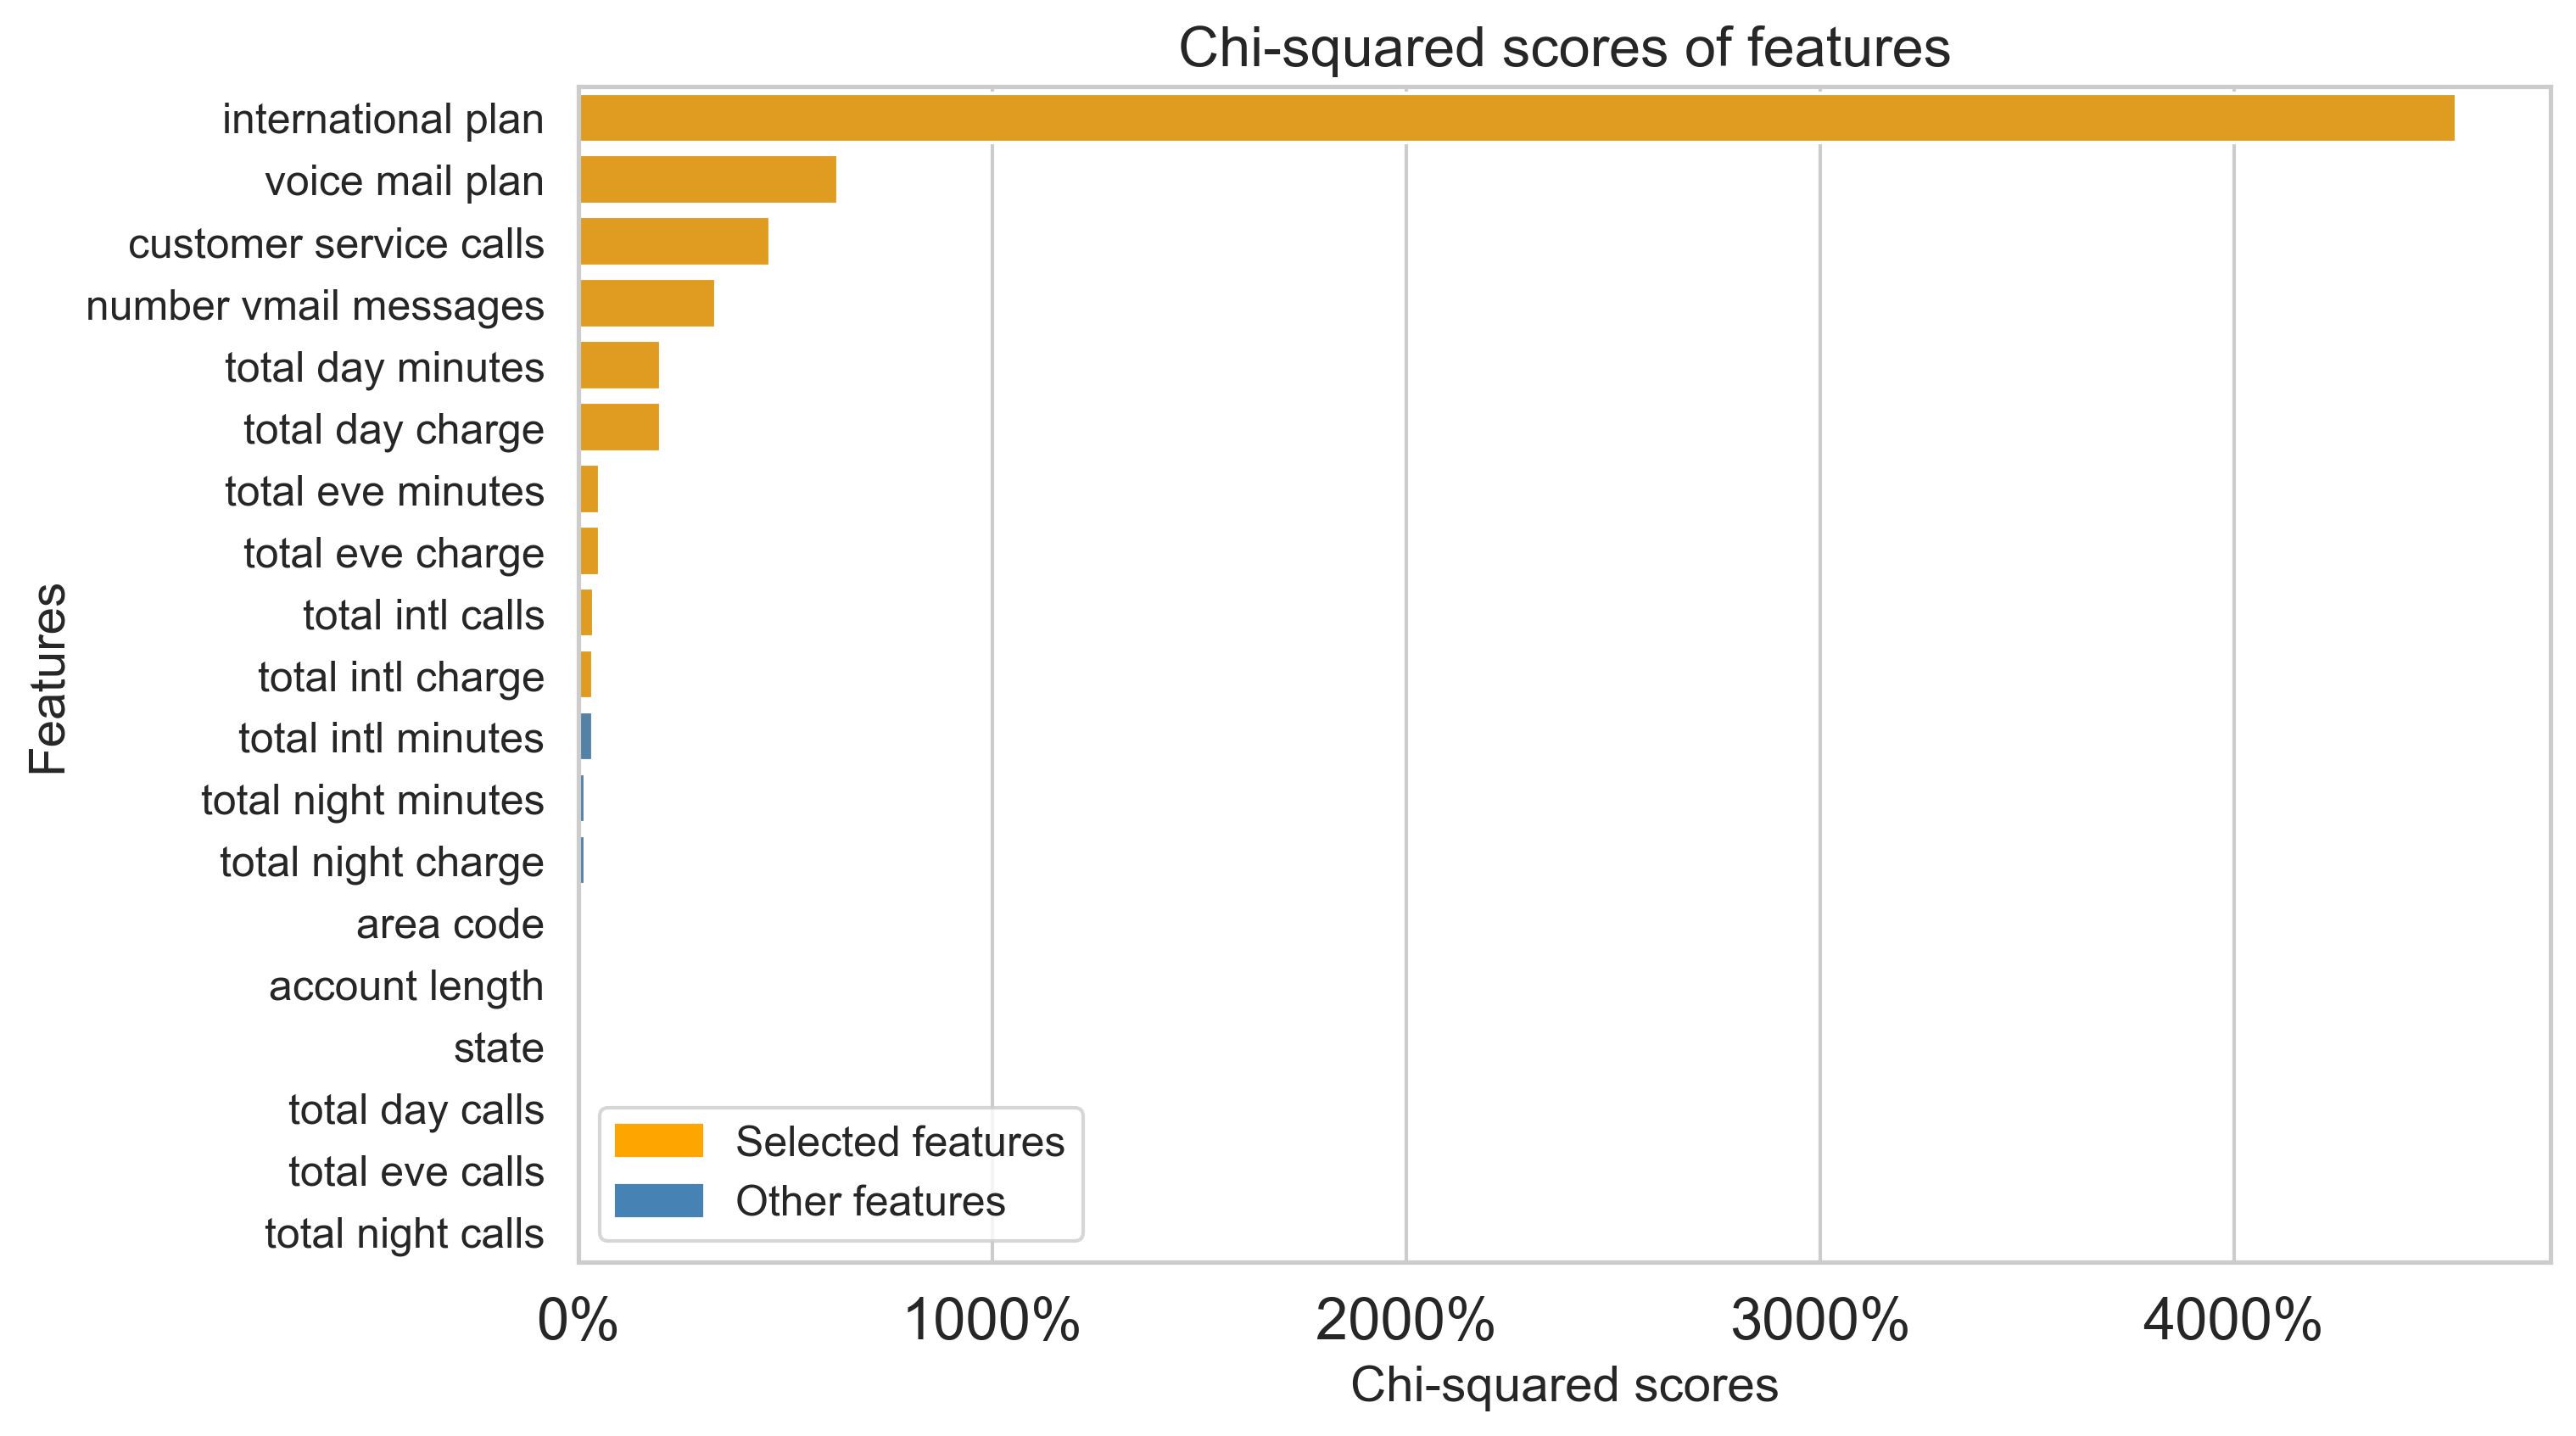

In [34]:
# plot the scores
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

# set default color for all bars
sns_color = 'steelblue'

# change color for selected features
bar_colors = [sns_color if f not in chi_sq_features else 'orange' for f in sorted_feature_names]

sns.barplot(x=sorted_scores, y=sorted_feature_names, palette=bar_colors)

# Set x-axis label
ax.set_xlabel(r'Chi-squared scores', fontsize=14)

# Set y-axis label
ax.set_ylabel(r'Features', fontsize=14)

# Format y-axis tick labels
ax.tick_params(axis='y', labelsize=12)

# Format x-axis tick labels as percentages
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))

# Add legend for selected features
selected_patch = mpatches.Patch(color='orange', label='Selected features')
sns_patch = mpatches.Patch(color=sns_color, label='Other features')
plt.legend(handles=[selected_patch, sns_patch], prop={'size': 12})

# Set title
ax.set_title(r'Chi-squared scores of features', fontsize=16)

# Save the figure in different formats suitable for submission
plt.savefig('fs_chi2.pdf', bbox_inches='tight')
plt.savefig('fs_chi2.png', bbox_inches='tight', dpi=300)
plt.savefig('fs_chi2.eps', bbox_inches='tight')

plt.show()


In [ ]:
# # create a figure with 2 subplots
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,7), dpi = 120)

# # plot the correlation values in the first subplot
# sns.barplot(x=corr.values, y=corr.index, ax=ax[0])
# ax[0].set_xlabel('Correlation with target variable')
# ax[0].set_ylabel('Features')


# # plot the Chi-squared scores in the second subplot
# sns.barplot(x=sorted_scores, y=sorted_feature_names, ax=ax[1])
# ax[1].set_xlabel('Chi-squared scores')
# ax[1].set_ylabel('Features')


# # save the figure
# plt.savefig('Correlation_Chi2.svg')
# plt.show()

### Forward  Selection

In [37]:
# create model
model = RandomForestClassifier()


pipeline_sfs = Pipeline([
    ('scaler', MinMaxScaler().set_output(transform="pandas")),
    ('model', model)
])

In [40]:
gmean_scorer = make_scorer(geometric_mean_score)
spec_scorer = make_scorer(specificity_score)

In [41]:
# separate the target variable
y = df_encoded['churn']
X = df_encoded.drop(columns=['churn'])

# initialize the feature selector
sfs = SFS(pipeline_sfs, k_features='best', forward=False, floating=False, scoring=gmean_scorer, cv=10, n_jobs=-1)

# fit the feature selector
sfs = sfs.fit(X, y)

# get the selected features
seq_fea_sel_features = list(sfs.k_feature_names_)


# print the selected features
print(seq_fea_sel_features)

['international plan', 'voice mail plan', 'number vmail messages', 'total day minutes', 'total day charge', 'total eve minutes', 'total eve charge', 'total night minutes', 'total night charge', 'total intl calls', 'total intl charge', 'customer service calls']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


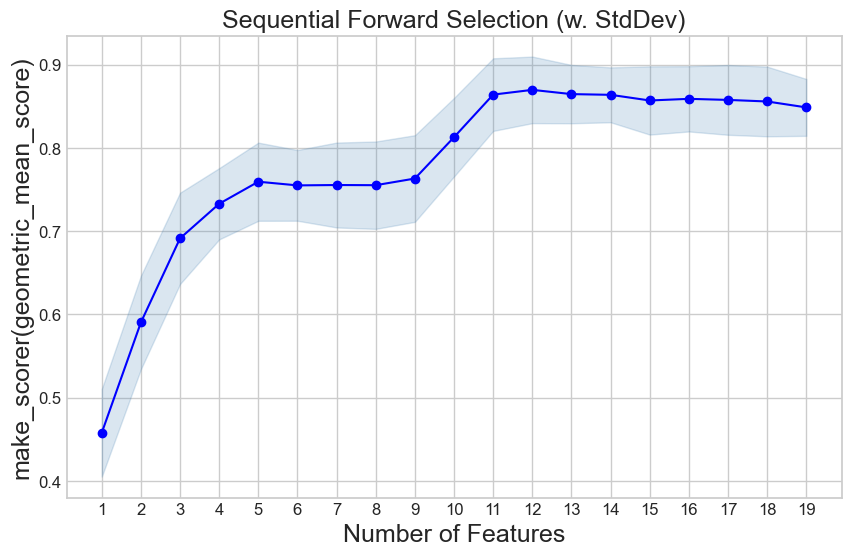

In [47]:
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev', figsize=(10, 6))

# Add a legend to the figure
# plt.legend(loc='best')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.xlabel('Number of Features')
plt.ylabel(f'{sfs.scoring}')
plt.grid(True)

# Format axis labels and ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().tick_params(axis='both', which='both', length=0)

# Format legend
# plt.legend('CV Score', fontsize=12)

# Save the figure in different formats suitable for submission
plt.savefig('fs_seq_fea_sel.pdf', bbox_inches='tight')
plt.savefig('fs_seq_fea_sel.png', bbox_inches='tight', dpi=300)
plt.savefig('fs_seq_fea_sel.eps', bbox_inches='tight')

plt.show()

### RFECV

In [48]:
class MyPipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_

In [49]:
scaler = MinMaxScaler()
model = RandomForestClassifier(n_jobs=-1, random_state=42)
pipeline_rfecv = MyPipeline(steps=[("scale",scaler),("model", model)])

In [52]:
# separate the target variable
y = df_encoded['churn']
X = df_encoded.drop(columns=['churn'])

rfecv = RFECV(pipeline_rfecv, cv=StratifiedKFold(n_splits=10, shuffle=True), scoring=gmean_scorer, n_jobs=-1)


# fit the feature selector
rfecv = rfecv.fit(X, y)

# Get the column names of the best features
rfe_cv_features = X.columns[rfecv.support_]

# print the column names of the selected features
print("Column names of the best features:")
print(rfe_cv_features)

Column names of the best features:
Index(['international plan', 'number vmail messages', 'total day minutes',
       'total day charge', 'total eve minutes', 'total eve charge',
       'total night minutes', 'total night charge', 'total intl minutes',
       'total intl calls', 'total intl charge', 'customer service calls'],
      dtype='object')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


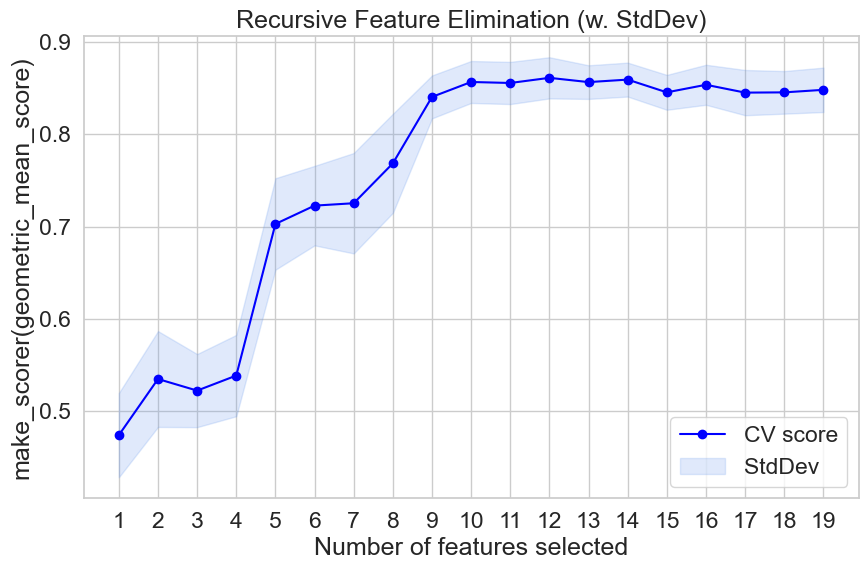

In [53]:
# Plot the number of features VS. cross-validation scores
plt.figure(figsize=(10, 6))
plt.title('Recursive Feature Elimination (w. StdDev)')
plt.xlabel('Number of features selected')
plt.ylabel(f'{rfecv.scoring}')
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], label='CV score', marker='o', color='blue')

# Plot the standard deviation as a shaded region
plt.fill_between(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), 
                 rfecv.cv_results_['mean_test_score'] - rfecv.cv_results_['std_test_score'],
                 rfecv.cv_results_['mean_test_score'] + rfecv.cv_results_['std_test_score'], 
                 alpha=0.2, label='StdDev', color='cornflowerblue')

# Set x-axis tick labels as integers
plt.xticks(list(range(1, len(rfecv.cv_results_['mean_test_score']) + 1)))

plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('fs_rfecv.png', dpi=300)
plt.savefig('fs_rfecv.pdf')
plt.savefig('fs_rfecv.eps')
plt.show()


In [54]:
def evaluate_performance(X, y, features, model=RandomForestClassifier(random_state=42)):
    # Get the start time
    start_time = time.time()
    # Select the specified features
    X = X[features]
    
    # initialize the model
    clf = pipeline_sfs
    
    # define the k-fold cross validation
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    gmean_scorer = make_scorer(geometric_mean_score)
    spec_scorer = make_scorer(specificity_score)
    
    # get the accuracy, precision, recall and roc auc score
    accuracy = cross_val_score(clf, X, y, cv=kfold, scoring='accuracy', n_jobs=-1)
    precision = cross_val_score(clf, X, y, cv=kfold, scoring='precision', n_jobs=-1)
    recall = cross_val_score(clf, X, y, cv=kfold, scoring='recall', n_jobs=-1)
    roc_auc = cross_val_score(clf, X, y, cv=kfold, scoring='roc_auc', n_jobs=-1)
    g_mean = cross_val_score(clf, X, y, cv=kfold, scoring=gmean_scorer, n_jobs=-1)
    spec_score = cross_val_score(clf, X, y, cv=kfold, scoring=spec_scorer, n_jobs=-1)
    mcc_score = cross_val_score(clf, X, y, cv=kfold, scoring='matthews_corrcoef', n_jobs=-1)
    
    end_time = time.time()
    
    # fit the model
    # clf.fit(X, y)
    
    # get false positive rate, true positive rate and threshold
    # fpr, tpr, threshold = roc_curve(y, clf.predict_proba(X)[:,1])
    # roc_score = roc_auc_score(y, clf.predict_proba(X)[:,1])
    
    #Storing the results in a dictionary
    result = {}
    result['accuracy'] = np.mean(accuracy)
    result['precision'] = np.mean(precision)
    result['recall'] = np.mean(recall)
    result['roc_auc'] = np.mean(roc_auc)
    result['gmean'] = np.mean(g_mean)
    result['specificity'] = np.mean(spec_score)
    result['mcc'] = np.mean(mcc_score)
    result['time'] = end_time - start_time
    
    return result

### Saving the best features

In [ ]:
# corr_features = ['international plan', 'customer service calls', 'total day minutes',
#        'total day charge', 'voice mail plan', 'total eve minutes',
#        'total eve charge', 'number vmail messages', 'total intl charge',
#        'total intl minutes']

# chi_sq_features = ['international plan', 'voice mail plan', 'customer service calls',
#        'number vmail messages', 'total day minutes', 'total day charge',
#        'total eve minutes', 'total eve charge', 'total intl calls',
#        'total intl charge']

# seq_fea_sel_features = ['international plan', 'voice mail plan', 'number vmail messages', 
#                      'total day minutes', 'total day charge', 'total eve minutes', 'total eve calls', 
#                      'total eve charge', 'total night minutes', 'total night charge', 'total intl minutes', 
#                      'total intl calls', 'total intl charge', 'customer service calls']

# rfe_cv_features = ['international plan', 'number vmail messages', 'total day minutes',
#        'total day charge', 'total eve minutes', 'total eve charge',
#        'total night minutes', 'total night charge', 'total intl minutes',
#        'total intl calls', 'total intl charge', 'customer service calls']

In [55]:
with open('selected_features.pkl', 'wb') as f:
    pickle.dump([corr_features, chi_sq_features, seq_fea_sel_features, rfe_cv_features], f)

In [56]:
all_features = list(X.columns)

In [57]:
ep_all = evaluate_performance(X, y, all_features)

In [58]:
ep_corr = evaluate_performance(X, y, corr_features)

In [59]:
ep_chi2 = evaluate_performance(X, y,chi_sq_features)

In [60]:
ep_sfs = evaluate_performance(X, y, seq_fea_sel_features)

In [61]:
ep_rfe = evaluate_performance(X, y, rfe_cv_features)

### Result Table

In [62]:
# create a list of the dictionaries
dict_list = [ep_all, ep_corr, ep_chi2, ep_sfs, ep_rfe]
dict_list_name = ['base', 'correlation', 'chi2', 'sfs', 'rfe']
df_result = pd.DataFrame(dict_list, index=[d for d in dict_list_name])
df_result

,accuracy,precision,recall,roc_auc,gmean,specificity,mcc,time
base,0.953185,0.940176,0.721854,0.909173,0.852463,0.992281,0.804825,7.162113
correlation,0.933987,0.867832,0.662117,0.905357,0.806131,0.982456,0.721916,5.818417
chi2,0.951386,0.914509,0.755187,0.919424,0.857635,0.986667,0.803802,5.855498
sfs,0.961288,0.941433,0.769728,0.913742,0.871012,0.990877,0.824258,6.235169
rfe,0.958586,0.943680,0.753061,0.912988,0.869864,0.992632,0.822801,6.471026


In [ ]:
# ax = plt.subplot(111, frame_on=False) # no visible frame
# ax.xaxis.set_visible(False)  # hide the x axis
# ax.yaxis.set_visible(False)  # hide the y axis

# table(ax, df_result)  # where df is your data frame

# plt.savefig('mytable.png')

In [63]:
df_styled = df_result.style.background_gradient()
df_styled

,accuracy,precision,recall,roc_auc,gmean,specificity,mcc,time
base,0.953185,0.940176,0.721854,0.909173,0.852463,0.992281,0.804825,7.162113
correlation,0.933987,0.867832,0.662117,0.905357,0.806131,0.982456,0.721916,5.818417
chi2,0.951386,0.914509,0.755187,0.919424,0.857635,0.986667,0.803802,5.855498
sfs,0.961288,0.941433,0.769728,0.913742,0.871012,0.990877,0.824258,6.235169
rfe,0.958586,0.943680,0.753061,0.912988,0.869864,0.992632,0.822801,6.471026
